## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import time
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
import tensorflow as tf

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.plot_tools import plot
from library.utils import file_utils
from library.tf.linear_classifier import LinearClassifier

## Select Tensorflow device

In [4]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# cpu_devices = [x.name for x in local_device_protos if x.device_type == 'CPU']
# gpu_devices = [x.name for x in local_device_protos if x.device_type == 'GPU']
# print('Available CPU Devices: ', end='')
# print(cpu_devices)
# print('Available GPU Devices: ', end='')
# print(gpu_devices)
# if len(gpu_devices) == 0:
#     if len(cpu_devices) > 0:
#         device_name = '/cpu:0'
#         print('Using CPU: %s' %device_name)
#     else:
#         print('No CPU present in the system!!!')
# else:
#     device_name = '/gpu:0'
#     print('Using GPU: %s' %device_name)

In [5]:
total_time = 0

## Experiment

In [6]:
exp_no = 5
data_source = 'Website'
num_images_required = 0.1
file_no = 101

### Parameters for experiment

In [7]:
device_name = '/gpu:0'
learn_rate = 1.5
train_epochs = 100
display_step = 1
reg_const = 0.01
train_val_split_data = None
train_val_split = 0.8
transform = True
transform_method = 'StandardScaler'
learn_rate_type = 'constant'
dataset = 'cifar10'

### Log directories

In [8]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(3) + '_tf_linear_raw/exp_no_' + str(exp_no).zfill(3) + '/'
log_file = log_dir + 'linear_classifier.ckpt'
model_file = log_dir + 'linear_classifier.pb'
print('Writing tensorboard logs to %s' % log_file)
print('View logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./%s/101_tf_linear_raw/\' --port 61111\"' %dataset)

Writing tensorboard logs to ../logs/cifar10/101_tf_linear_raw/exp_no_005/linear_classifier.ckpt
View logs by running tensorboard: "tensorboard --logdir='./cifar10/101_tf_linear_raw/' --port 61111"


## Step 1: Load CIFAR 10 Dataset

In [9]:
start = time.time()
one_hot = True
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, preprocess='StandardScaler',
                  train_validate_split=train_val_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 1] Loaded CIFAR 10 Dataset in %.4f ms' %((end-start)*1000))
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 5000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5


/net/voxel03/misc/me/praneethas/Softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 5.5833 seconds
[ Step 1] Loaded CIFAR 10 Dataset in 5584.1920 ms


In [10]:
# print('Train data shape:', cifar10.train.data.shape)
# if one_hot is True:
#     print('Train labels shape:', cifar10.train.one_hot_labels.shape)
# print('Train class labels shape:', cifar10.train.class_labels.shape)
# if train_val_split_data is not None:
#     print('Validate data shape:', cifar10.validate.data.shape)
#     if one_hot is True:
#         print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
#     print('Validate class labels shape:', cifar10.validate.class_labels.shape)
# print('Test data shape:', cifar10.test.data.shape)
# if one_hot is True:
#     print('Test labels shape:', cifar10.test.one_hot_labels.shape)
# print('Test class labels shape:', cifar10.test.class_labels.shape)

In [11]:
# print('Training images')
# print(cifar10.train.data[:5])
# if one_hot is True:
#     print('Training labels')
#     print(cifar10.train.one_hot_labels[:5])
# print('Training classes')
# print(cifar10.train.class_labels[:5])
# print('Testing images')
# print(cifar10.test.data[:5])
# if one_hot is True:
#     print('Testing labels')
#     print(cifar10.test.one_hot_labels[:5])
# print('Testing classes')
# print(cifar10.test.class_labels[:5])

## Step 1.1 Load sample images

In [12]:
# cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

In [13]:
# cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
#                     nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Linear Regression

### Step 2.1: Model linear regression y = Wx + b

In [14]:
num_features = cifar10.train.data.shape[1]
num_classes = 10

In [15]:
network_config = {'weight': {'type': 'zeros', 'name': 'Weight'},
                  'bias': {'type': 'ones', 'name': 'Bias'},
                  'activation_fn': 'softmax',
                  'descent_method': 'gradient'}

In [16]:
lc = LinearClassifier(verbose=False, device=device_name, session_type='interactive', num_iter=train_epochs, 
                      err_tolerance=1e-7, train_validate_split=train_val_split, display_step=display_step,
                      learn_step=10, learn_rate_type=learn_rate_type, learn_rate=learn_rate, reg_const=reg_const, 
                      logs=True, log_dir=log_dir, test_log=True, save_model=True, checkpoint_filename=log_file, 
                      save_checkpoint=True, restore=False, model_name=model_file, config=network_config)

### Step 2.2: Create the tensorflow graph

In [17]:
start = time.time()
lc.create_graph(num_features=num_features, num_classes=num_classes)
end = time.time()
print('Generated the tensorflow graph in %.4f ms' %((end-start)*1000))
total_time = (end-start)

Session: <tensorflow.python.client.session.InteractiveSession object at 0x7fe109fbdb00>
Model has been trained for 0 iterations
Tensorflow graph created in 0.9516 seconds
Generated the tensorflow graph in 951.9534 ms


In [18]:
lc.print_parameters()

Parameters for MLP classifier
>> Input Parameters
Input                  : Tensor("Inputs/Data/X_input:0", shape=(?, 3072), dtype=float32, device=/device:GPU:0) 
True one hot labels    : Tensor("Inputs/Train_Labels/y_true_one_hot_label:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
True class             : Tensor("Inputs/Train_Labels/y_true_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
Predict one hot labels : Tensor("Predictions/one_hot:0", shape=(?, 10), dtype=float32, device=/device:GPU:0) 
Predict class          : Tensor("Predictions/predict_class:0", shape=(?,), dtype=int64, device=/device:GPU:0) 
>> Model params
last_successful_epoch/initial_value
last_successful_epoch
last_successful_epoch/Assign
last_successful_epoch/read
add/y
add
assign_updated_epoch
Inputs/Data/X_input
Inputs/Train_Labels/y_true_one_hot_label
Inputs/Train_Labels/y_true_class
Parameters/Weights/zeros
Parameters/Weights/Weight
Parameters/Weights/Weight/Assign
Parameters/Weights/Weight/rea

### Step 2.3: Fit the model/training

In [19]:
start = time.time()
lc.fit(cifar10.train.data, cifar10.train.one_hot_labels, cifar10.train.class_labels,
       test_data=cifar10.test.data, test_labels=cifar10.test.one_hot_labels, test_classes=cifar10.test.class_labels)
end = time.time()
print('Fit completed in %.4f seconds' % (end-start))

Length of train loss          : 0
Length of train accuracy      : 0
Length of validate loss       : 0
Length of validate accuracy   : 0
Length of test accuracy       : 0
Restoring training from epoch : 0
>>> Epoch [  0/100]
train_loss: 2.3026 | train_acc: 0.0995 | val_loss: 2.1813 | val_acc: 0.2680 | test_acc: 0.2616 | Time: 0.5103 s
>>> Epoch [  1/100]
train_loss: 2.1842 | train_acc: 0.2643 | val_loss: 2.2250 | val_acc: 0.2230 | test_acc: 0.2243 | Time: 0.2523 s
>>> Epoch [  2/100]
train_loss: 2.2100 | train_acc: 0.2420 | val_loss: 2.2099 | val_acc: 0.2390 | test_acc: 0.2327 | Time: 0.2753 s
>>> Epoch [  3/100]
train_loss: 2.1896 | train_acc: 0.2610 | val_loss: 2.1799 | val_acc: 0.2670 | test_acc: 0.2750 | Time: 0.2551 s
>>> Epoch [  4/100]
train_loss: 2.1544 | train_acc: 0.3028 | val_loss: 2.1773 | val_acc: 0.2700 | test_acc: 0.2849 | Time: 0.2539 s
>>> Epoch [  5/100]
train_loss: 2.1469 | train_acc: 0.3100 | val_loss: 2.1610 | val_acc: 0.2970 | test_acc: 0.2937 | Time: 0.2360 s
>>> 

### Step 2.4: Make the predictions

In [20]:
prediction_numbers = lc.predict(cifar10.test.data)
prediction_classes = []
num_test_images = cifar10.test.data.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])

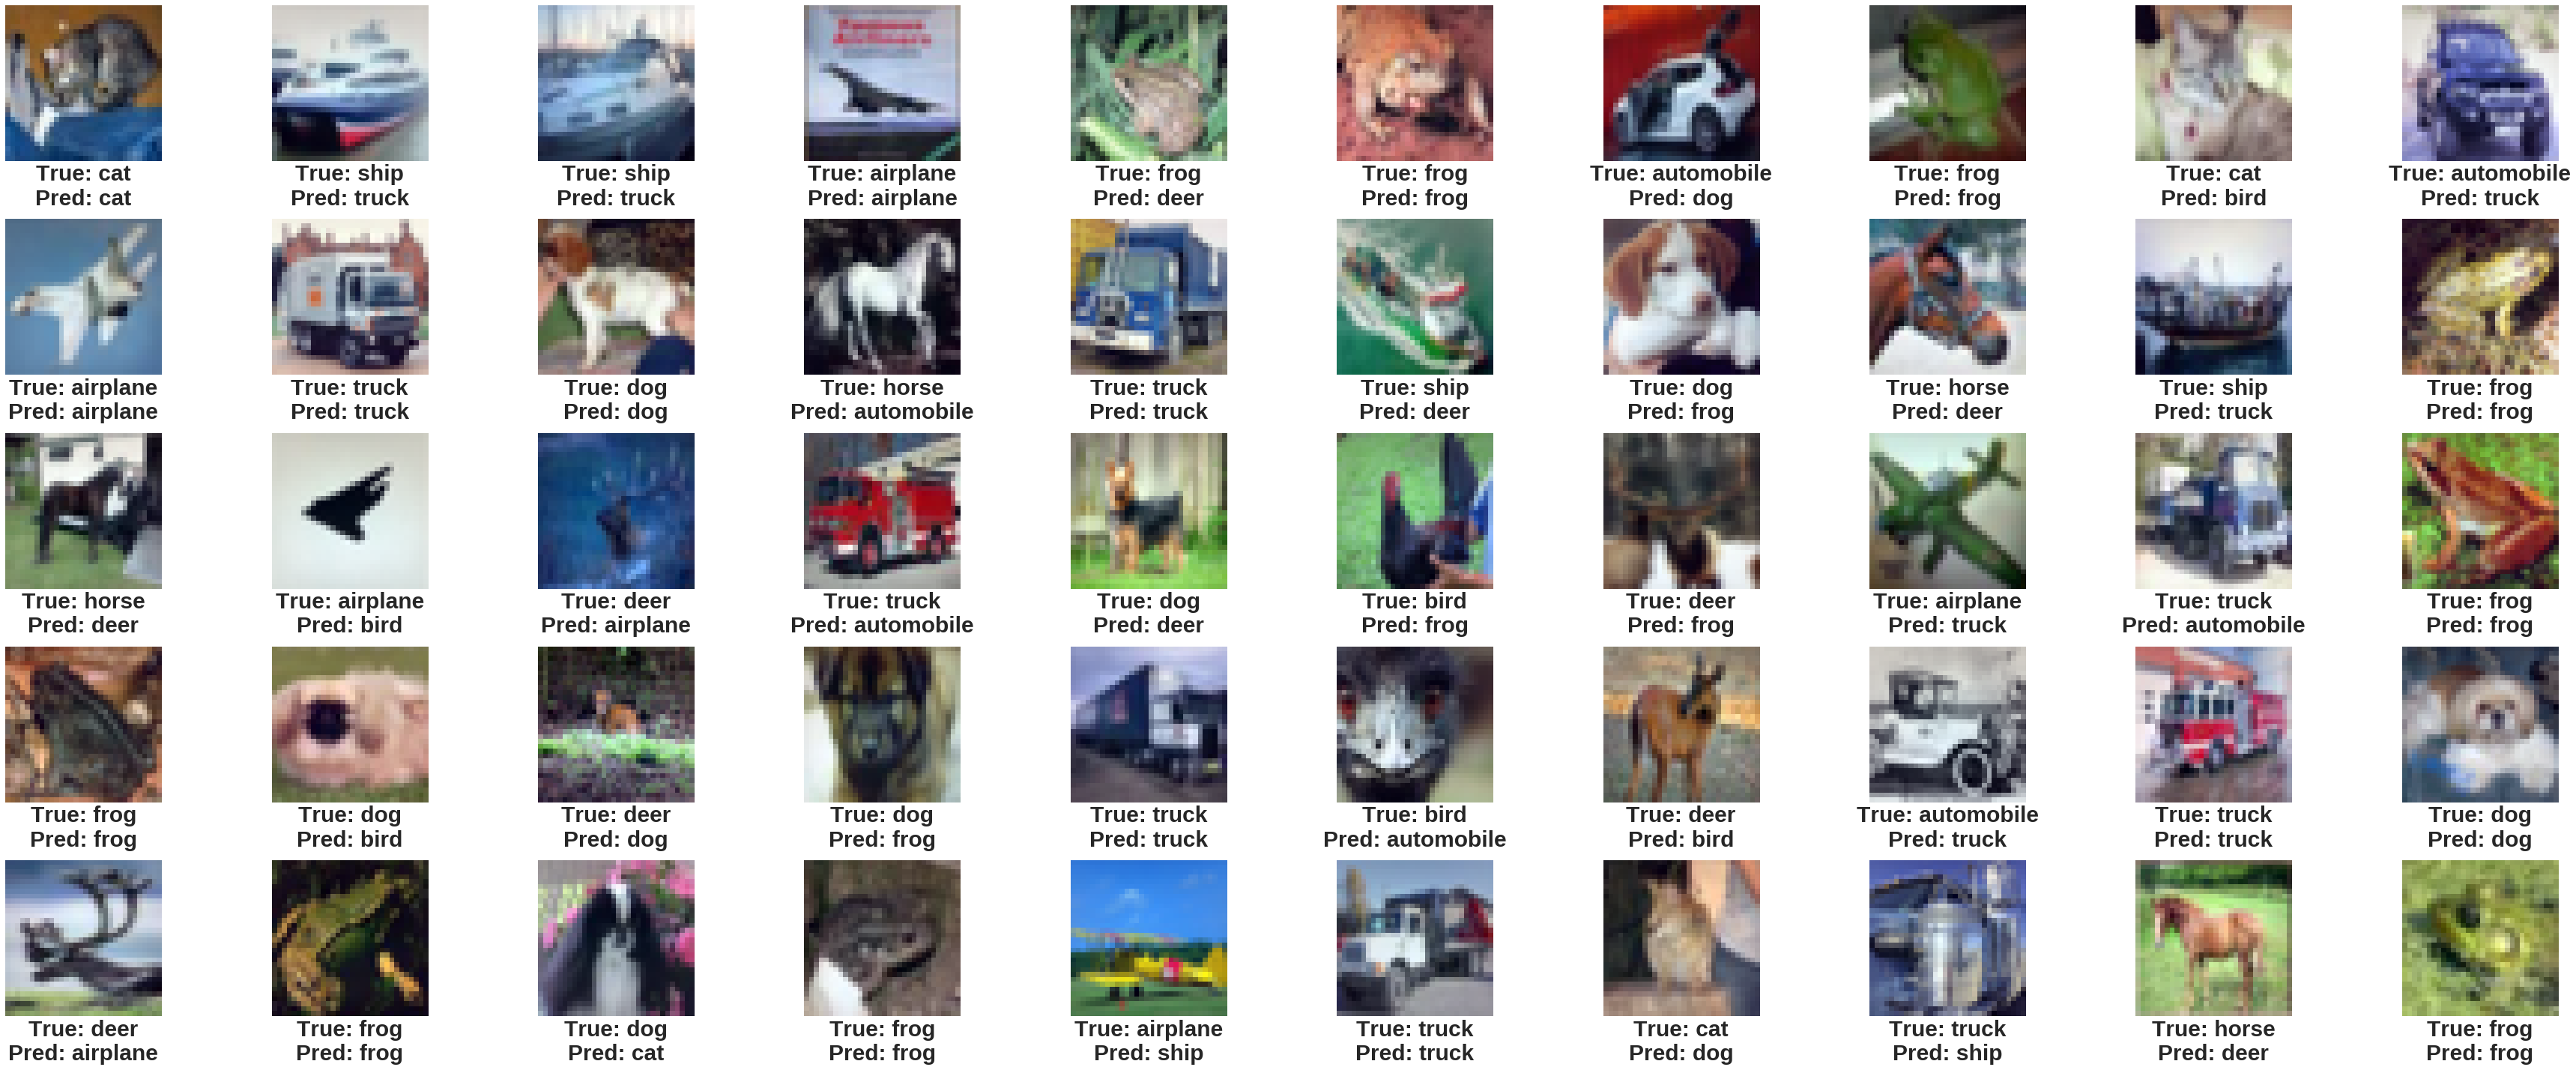

True

In [21]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

### Step 2.5: Print the results

In [22]:
test_accuracy = lc.score(cifar10.test.data, cifar10.test.class_labels)
print('Accuracy of the linear classifier on test dataset: %.4f' % test_accuracy)

Accuracy of the linear classifier on test dataset: 0.3535


Confusion matrix, without normalization
[[506  42  44  10  26  33  27  45 112 155]
 [ 63 355  13  33  31  55  55  33  69 293]
 [143  34 202  72 139  92 160  80  37  41]
 [ 74  47  74 172  71 245 126  71  34  86]
 [ 61  40 102  66 289  73 189  99  31  50]
 [ 39  28  95 110  85 372 117  77  33  44]
 [ 25  38  76  78 110 108 438  28  29  70]
 [ 53  53  56  47 136  73  66 350  37 129]
 [205  52  17  21  15  82   9  23 303 273]
 [ 64 129  17  26  18  37  51  39  71 548]]
Normalized confusion matrix
[[ 0.506  0.042  0.044  0.01   0.026  0.033  0.027  0.045  0.112  0.155]
 [ 0.063  0.355  0.013  0.033  0.031  0.055  0.055  0.033  0.069  0.293]
 [ 0.143  0.034  0.202  0.072  0.139  0.092  0.16   0.08   0.037  0.041]
 [ 0.074  0.047  0.074  0.172  0.071  0.245  0.126  0.071  0.034  0.086]
 [ 0.061  0.04   0.102  0.066  0.289  0.073  0.189  0.099  0.031  0.05 ]
 [ 0.039  0.028  0.095  0.11   0.085  0.372  0.117  0.077  0.033  0.044]
 [ 0.025  0.038  0.076  0.078  0.11   0.108  0.438  0.028  0.02

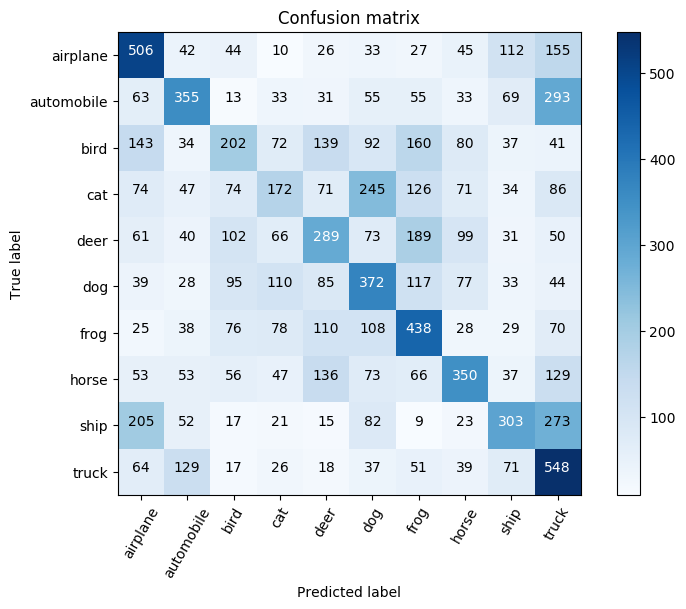

Detailed classification report
             precision    recall  f1-score   support

   airplane       0.41      0.51      0.45      1000
 automobile       0.43      0.35      0.39      1000
       bird       0.29      0.20      0.24      1000
        cat       0.27      0.17      0.21      1000
       deer       0.31      0.29      0.30      1000
        dog       0.32      0.37      0.34      1000
       frog       0.35      0.44      0.39      1000
      horse       0.41      0.35      0.38      1000
       ship       0.40      0.30      0.35      1000
      truck       0.32      0.55      0.41      1000

avg / total       0.35      0.35      0.35     10000



In [23]:
lc.print_classification_results(cifar10.test.data, cifar10.test.one_hot_labels, cifar10.test.class_labels,
                                test_class_names=cifar10.classes, normalize=True)

### Step 2.6: Plot results

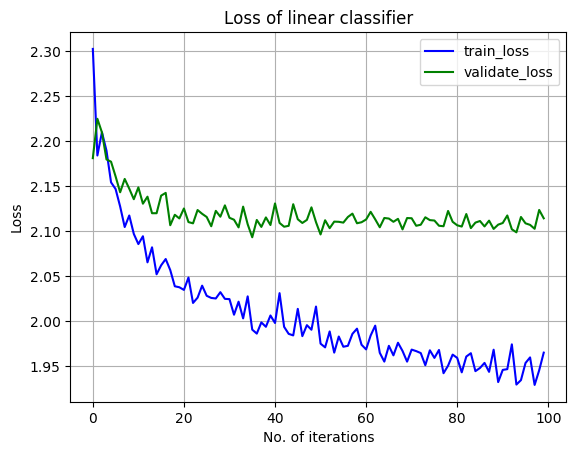

True

In [24]:
lc.plot_loss()

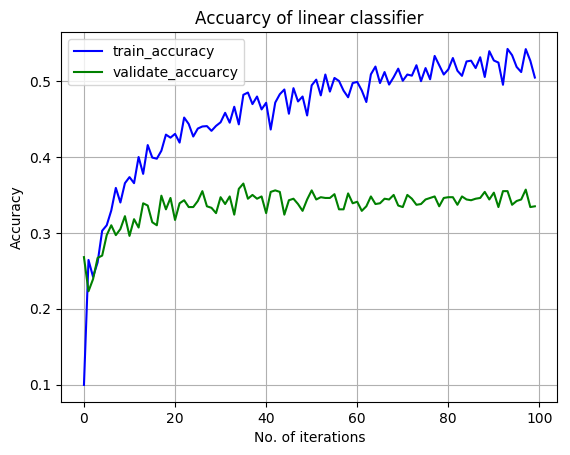

True

In [25]:
lc.plot_accuracy()

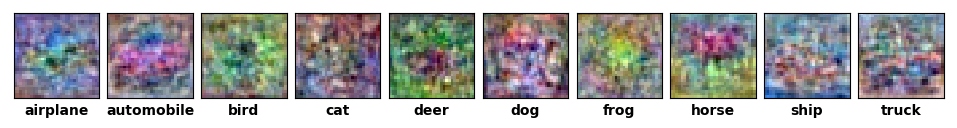

True

In [26]:
lc.plot_weights(classes=cifar10.classes)

### Step 2.7: Close the session

In [27]:
lc.close()

## Step 3: Write to file

In [28]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [29]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [30]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
current_file = './' + theNotebook + '.ipynb'
output_file = log_dir + str(file_no).zfill(2) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(log_dir) 
output_HTML(current_file, output_file)

NameError: name 'theNotebook' is not defined